#  Neighborhoods to build Gym in Toronto

project explanation:

# Goal: 
Today, the number of people paying more attention to exercise is increasing as they want to be more healthier, have fit body and live longer.people of Toronto are no exception. An investor is going to build a gym or maybe more in Toronto and is seeking for more suitable places. Two of the factor that can affect the decision are the population in the area and the income of the people as wealthier people enroll more in gyms on average. In this project, we are going to get the related data and cluster the neighborhoods based on the data. Then, based on these data, we suggest better neighborhoods to think of for investing on building the gym. 

# process:
0- installing and importing the required libraries

1- Getting and preparing postal codes of Toronto - Canada from *Wikipedia.org* (including postal code - boroughs and neighborhoods) - making a dataframe out of it

2- Downloading and reading a CSV file containing the postal codes and their latitudes and longitudes - making a dataframe out of it

3- Cleaning and merging the two dataframes 

4- population and household average income of Toronto neighborhoods - getting data from *www12.statcan.gc.ca*

5- Exploring the number of Gyms in each neighborhood using the *foursqaure*.

6- preparing the data and Clustering the neighborhoods using *Kmeans* clustering.

7- Visualizing the clusters using *folium*

8- choosing better neighborhoods


## 0- installing and importing the required libraries

In [1]:
import pandas as pd #library for data analysis
import numpy as np # library for working with vectors
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # for clustering
import matplotlib.cm as cm  #for better visualizing the results clusters by folium
import matplotlib.colors as colors  #for better visualizing the results clusters by folium
import matplotlib.pyplot as plt 

#installing beautifulsoup for website scraping 
!pip install beautifulsoup4
!pip install lxml html5lib beautifulsoup4
from bs4 import BeautifulSoup

!conda install -c conda-forge folium=0.5.0 --yes #installing folium (if not installed already) - map rendering library 
import folium # map rendering library

!pip install urllib3
from urllib.request import urlopen # Opening a network object denoted by a URL for reading

!pip install requests # to get url
import requests # library to handle requests

!pip install geopy 
from geopy.geocoders import Nominatim # a module to the lat and lng of a given address

!pip install geocoder
print('libraries are intalled and imported')

     |████████████████████████████████| 122kB 5.4MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 6.9MB/s eta 0:00:01     |█████████▏                      | 1.6MB 6.9MB/s eta 0:00:01  |████████████████████████████████| 5.5MB 6.9MB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d

## 1 - getting and preparing postal codes of Toronto

In [2]:
def getHTMLContent(link):
    html = urlopen(link)
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In the **getHTMLContent()** function, we pass in the URL. Here, we first open the url using the **urlopen** method. This enables us to apply **BeautifulSoup** library to get the HTML using a parser.

In [3]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
content = getHTMLContent(link)
tables = content.find_all('table')

checking the content of tables, we find that our desired data is in the table -- class : 'wikitable sortable' -- 

In [4]:
table = content.find('table', {'class': 'wikitable sortable'})
#table

A table in HTML is comprised of rows denoted by the tags **tr** .  Each row has cells which can either be headings defined using <th></th> **th** or data defined using <td></td> **td**. we use them to get the data needed. 

we append the postal codes, boroughs and neighborhoods to three lists of A, B, C  respectively and then make a dataframe out of them.

In [5]:
A=[]
B=[]
C=[]

for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) ==3:
        A.append(cells[0].find(text = True))
        B.append(cells[1].find(text = True))
        C.append(cells[2].find(text = True))


In [6]:
df=pd.DataFrame(A,columns=['PostalCode'])
df['Borough']=B
df['Neighborhood']=C
df

,PostalCode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"
...,...,...,...
175,M5Z\n,Not assigned\n,Not assigned\n
176,M6Z\n,Not assigned\n,Not assigned\n
177,M7Z\n,Not assigned\n,Not assigned\n
178,M8Z\n,Etobicoke\n,"Mimico NW, The Queensway West, South of Bloor,..."


### Cleaning the data:

* removing the "\n" form our dataframe items.
* removing the rows where the boroughs are not assigned and reseting the index 

In [7]:
df.replace(regex=['\n'], value='', inplace = True)
df2 = df[df['Borough']!= 'Not assigned']
df2.reset_index(drop = True, inplace = True)
df2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M4G,North York,Downsview
freq,1,24,4


checking whether there is any neighborhood which is not assigned

In [8]:
df2[df2['Neighborhood']=='Not assigned']

,PostalCode,Borough,Neighborhood


We checked to know if there is any "Not assigned" value in the "Neighborhood" and there was none. in case there is there is "Not assigned" value, we can use the following codes to replace the "Not assigned" values the Borough in the same row. 

In [9]:
idx = df2.index[df2['Neighborhood']=='Not assigned']
for index in idx:
    df2["Neighborhood"][index] = df["Borough"][index]

checking the shape of the dataframe

In [10]:
df2.shape

(103, 3)

### 2- doanloading and reading the 'CSV' file containing the latitude and longitude of different postal codes in Toronto

In [11]:
!wget -q -O 'toronto_data.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [13]:
toronto_data = pd.read_csv('toronto_data.csv')
toronto_data.rename(columns ={'Postal Code':'PostalCode'}, inplace = True)
toronto_data.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
toronto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PostalCode  103 non-null    object 
 1   Latitude    103 non-null    float64
 2   Longitude   103 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB


 ## 3- merging the two dataframes

In [15]:
Toronto = pd.merge(df2, toronto_data, left_on='PostalCode', right_on='PostalCode')
Toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [16]:
Toronto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    103 non-null    object 
 1   Borough       103 non-null    object 
 2   Neighborhood  103 non-null    object 
 3   Latitude      103 non-null    float64
 4   Longitude     103 non-null    float64
dtypes: float64(2), object(3)
memory usage: 4.8+ KB


### 4- population and household average income of Toronto neighborhoods 

Getting the household **median** and **average income** and also **population** of neighborhoods defined by the postal codes included in our dataframe

**Note** : As we are going to study the target population for attending the gym, we get the population with the **age** between **15 and 64**.

First, we make a list of Postal Codes that are in our collected data.

In [17]:
postal_code_list = Toronto['PostalCode']
postal_code_list = postal_code_list.tolist()

In [18]:
postal_code_list[0:10]

['M3A', 'M4A', 'M5A', 'M6A', 'M7A', 'M9A', 'M1B', 'M3B', 'M4B', 'M5B']

Getting the desired information from **www12.statcan.gc.ca** for our Postal Codes of Toronto

In [19]:
pop_2016 =[] # getting the population with the age between 15 and 64
med_income =[] # median income of househols
avg_income =[] # average income of households
for i in postal_code_list:
    link_i = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=FSA&Code1={}&Geo2=PR&Code2=01&SearchText={}&SearchType=Begins&SearchPR=01&B1=All&TABID=2&type=0#fnb12'.format(i,i)
    content = getHTMLContent(link_i)
    #tables = content.find_all('table')
    table = content.find('table', {'class': 'table table-condensed table-hover'})
    
    pop_2016_i = table.find('td', attrs= {'class':"text-top text-right", 'headers':"L2005 geo1 total1"})
    try:
        pop_2016_i= pop_2016_i.text.strip()
    except:
        pop_2016_i = np.nan
    
    med_income_i = table.find('td', attrs= {'class':"text-top text-right", 'headers':"L13002 geo1 total1"})
    try:
        med_income_i= med_income_i.text.strip()
    except:
        med_income_i = np.nan
    
    avg_income_i = table.find('td', attrs= {'class':"text-top text-right", 'headers':"L13011 geo1 total1"})
    try:
        avg_income_i= avg_income_i.text.strip()
    except:
        avg_income_i = np.nan
    
    pop_2016.append(pop_2016_i)
    med_income.append(med_income_i)
    avg_income.append(avg_income_i)
    
print('populations for selected postal_codes are (sample): ', pop_2016[0:10] )
print('median incomes for selected postal_codes are (sample): ', med_income[0:10] )
print('average incomes for selected postal_codes are (sample) : ', avg_income[0:10] )


populations for selected postal_codes are (sample):  ['23,575', '9,405', '32,905', '13,490', 'x', '24,065', '45,135', '8,235', '12,840', '11,085']
median incomes for selected postal_codes are (sample):  ['57,698', '49,453', '46,938', '49,060', 'x', '65,760', '62,789', '90,841', '54,234', '45,227']
average incomes for selected postal_codes are (sample) :  ['71,966', '60,491', '63,542', '62,881', 'x', '117,148', '70,929', '137,613', '71,178', '57,454']


Making a dataframe out of the collected data

In [20]:
data = [postal_code_list]
data = np.array(data)
data = data.T
df_n = pd.DataFrame(data, columns = ['PostalCode'])
df_n['Population'] = pop_2016
df_n['Median_income'] = med_income
df_n['Average_income'] = avg_income
df_n.head()

,PostalCode,Population,Median_income,Average_income
0,M3A,"23,575","57,698","71,966"
1,M4A,"9,405","49,453","60,491"
2,M5A,"32,905","46,938","63,542"
3,M6A,"13,490","49,060","62,881"
4,M7A,x,x,x


Checking the data and cleaning it.

In [22]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PostalCode      103 non-null    object
 1   Population      102 non-null    object
 2   Median_income   102 non-null    object
 3   Average_income  102 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


In [23]:
df_n.describe()

,PostalCode,Population,Median_income,Average_income
count,103,102,102,102
unique,103,96,97,97
top,M4G,x,x,x
freq,1,6,6,6


the data types are all objects and we have missing values. 
first, we change the data types and use *errors=coerce* to return *NaN* for values that are missing or have values other than numbers and can not be changed to int

In [24]:
df_n.replace(regex=[','], value='', inplace = True)
df_n['Population'] = pd.to_numeric(df_n['Population'], errors = 'coerce' )
df_n['Median_income'] = pd.to_numeric(df_n['Median_income'], errors = 'coerce' )
df_n['Average_income'] = pd.to_numeric(df_n['Average_income'], errors = 'coerce' )
df_n.head()

,PostalCode,Population,Median_income,Average_income
0,M3A,23575.0,57698.0,71966.0
1,M4A,9405.0,49453.0,60491.0
2,M5A,32905.0,46938.0,63542.0
3,M6A,13490.0,49060.0,62881.0
4,M7A,NaN,NaN,NaN


In [25]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PostalCode      103 non-null    object 
 1   Population      96 non-null     float64
 2   Median_income   96 non-null     float64
 3   Average_income  96 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.3+ KB


deleting rows with *NaN* values

In [26]:
df_n.dropna(how ='any', inplace = True)
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 102
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PostalCode      96 non-null     object 
 1   Population      96 non-null     float64
 2   Median_income   96 non-null     float64
 3   Average_income  96 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.8+ KB


In [27]:
df_n.describe()

,Population,Median_income,Average_income
count,96.000000,96.000000,96.000000
mean,19863.489583,62295.760417,88925.020833
std,10075.901661,14802.568766,41918.062375
min,1835.000000,37555.000000,47960.000000
25%,12486.250000,51676.250000,63854.000000
50%,18367.500000,59285.500000,73658.500000
75%,25522.500000,68231.500000,91718.250000
max,56475.000000,111821.000000,263796.000000


we got both household median and average incomes because sometimes due to some outliers, average is not a good representative. checking the data, it seems that there is a reasonable relation between median and average. therefore, we want to check more to know whether we can rely only on average or not. 

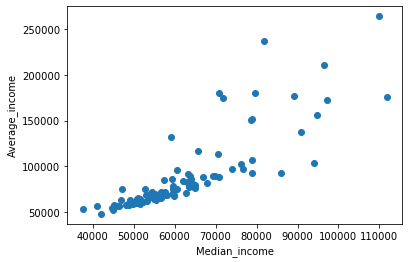

In [28]:
plt.scatter(df_n['Median_income'], df_n['Average_income'])
plt.xlabel('Median_income')
plt.ylabel('Average_income')
plt.show()

In [29]:
df_n['Median_income'].corr(df_n['Average_income'])

0.8366659304714593

the scatter plot and also the correlation between median and average shows that we can delete the median and continue our study based on the average of household income.

In [30]:
df_n = df_n.drop(['Median_income'], axis = 1)
df_n.head()

,PostalCode,Population,Average_income
0,M3A,23575.0,71966.0
1,M4A,9405.0,60491.0
2,M5A,32905.0,63542.0
3,M6A,13490.0,62881.0
5,M9A,24065.0,117148.0


Merging the new data with previous data

In [31]:
to_data = pd.merge(Toronto, df_n, on = 'PostalCode')
to_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Average_income
0,M3A,North York,Parkwoods,43.753259,-79.329656,23575.0,71966.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,9405.0,60491.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,32905.0,63542.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,13490.0,62881.0
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,24065.0,117148.0


In [32]:
to_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PostalCode      96 non-null     object 
 1   Borough         96 non-null     object 
 2   Neighborhood    96 non-null     object 
 3   Latitude        96 non-null     float64
 4   Longitude       96 non-null     float64
 5   Population      96 non-null     float64
 6   Average_income  96 non-null     float64
dtypes: float64(4), object(3)
memory usage: 6.0+ KB


### 5- exploring the number of Gyms in each neighborhood using the foursqaure

first we check the response for one neighborhood. Then, based on that, we provide a function to return the venues for all neighborhoods in our data.

In [33]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(to_latitude, to_longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [34]:
neighborhood_latitude = Toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


Importing the foursqaure credentials

In [35]:
CLIENT_ID = 'TZUWG4AZN1DFC0ETKYXJ1RSWWL43ZRCGNS4QH13KW1BGEWHQ' # your Foursquare ID
CLIENT_SECRET = 'Z5F5VWAHNQDRE2AF1XXDEPQYUK5DBBJW3UQK1P0CF4ST1TDP' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TZUWG4AZN1DFC0ETKYXJ1RSWWL43ZRCGNS4QH13KW1BGEWHQ
CLIENT_SECRET:Z5F5VWAHNQDRE2AF1XXDEPQYUK5DBBJW3UQK1P0CF4ST1TDP


setting the url for getting information about the venues from foursqaure

In [36]:
query = 'Gym'
radius =2000
LIMIT = 200
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,neighborhood_latitude,neighborhood_longitude,VERSION,query,radius,LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=TZUWG4AZN1DFC0ETKYXJ1RSWWL43ZRCGNS4QH13KW1BGEWHQ&client_secret=Z5F5VWAHNQDRE2AF1XXDEPQYUK5DBBJW3UQK1P0CF4ST1TDP&ll=43.7532586,-79.3296565&v=20180604&query=Gym&radius=2000&limit=200'

In [37]:
results = requests.get(url)
result1 = results.json()
result1

{'meta': {'code': 200, 'requestId': '5ef9df9f2f5bc4555b425886'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'gym',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 43.77125861800002,
    'lng': -79.30478345939711},
   'sw': {'lat': 43.735258581999986, 'lng': -79.35452954060288}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c18e819d4d9c9284e19f029',
       'name': 'LA Fitness',
       'location': {'address': '1380 Don Mills Road',
        'crossStreet': 'Mallard Rd',
        'lat': 43.74766522888878,
        'lng': -79.347076960652

In [38]:
response1= result1['response']
response1['totalResults']

8

function to return number of Gyms in the vicinity of each neighborhood

In [39]:
def getNumNearbyGyms(postalcodes,latitudes,longitudes, radius=1000, query ='Gym', LIMIT = 200):
    number_of_gyms =[] #number of gyms in vicinity of neighborhoods
    p_c= [] # keeping postla codes
    for pc, lat, lng in zip(postalcodes, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,lat,lng,VERSION,query,radius,LIMIT)
        results = requests.get(url).json()
        response = results['response']
        try:
            num_of_gyms = response['totalResults']
        except: # if there is no result or the result is not mentioned
            num_of_gyms = 0
        number_of_gyms.append(num_of_gyms)
        p_c.append(pc)
    pc_gyms = pd.DataFrame(p_c, columns = ['PostalCode'])
    pc_gyms['Num_of_gyms'] = number_of_gyms
    return(pc_gyms)

In [40]:
to_data_gyms = getNumNearbyGyms(postalcodes=to_data['PostalCode'],
                                   latitudes=to_data['Latitude'],
                                   longitudes=to_data['Longitude'])
print(to_data_gyms.shape)
to_data_gyms.head(10)

(96, 2)


,PostalCode,Num_of_gyms
0,M3A,0
1,M4A,2
2,M5A,19
3,M6A,2
4,M9A,0
5,M1B,2
6,M3B,2
7,M4B,2
8,M5B,62
9,M6B,6


Merging the new data with previous data

In [41]:
to_data_n = pd.merge(to_data, to_data_gyms, on ='PostalCode')
to_data_n.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Average_income,Num_of_gyms
0,M3A,North York,Parkwoods,43.753259,-79.329656,23575.0,71966.0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,9405.0,60491.0,2
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,32905.0,63542.0,19
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,13490.0,62881.0,2
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,24065.0,117148.0,0
5,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,45135.0,70929.0,2
6,M3B,North York,Don Mills,43.745906,-79.352188,8235.0,137613.0,2
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,12840.0,71178.0,2
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,11085.0,57454.0,62
9,M6B,North York,Glencairn,43.709577,-79.445073,18830.0,85675.0,6


### 6- preparing data and clustering using Kmeans

In [42]:
to_data_n.describe()

,Latitude,Longitude,Population,Average_income,Num_of_gyms
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,43.708566,-79.396472,19863.489583,88925.020833,8.947917
std,0.052123,0.097749,10075.901661,41918.062375,17.164449
min,43.602414,-79.594054,1835.000000,47960.000000,0.000000
25%,43.667357,-79.464763,12486.250000,63854.000000,0.000000
50%,43.706573,-79.392309,18367.500000,73658.500000,2.000000
75%,43.750743,-79.340219,25522.500000,91718.250000,7.250000
max,43.836125,-79.160497,56475.000000,263796.000000,90.000000


the population of people living in a neighborhood and also the average income of its households can be factors affecting the suitability of the neighborhood for building a Gym.besides, the number of existing Gyms in the neighborhood has a negative effect on the intention for an investor to provide budget for a new Gym. therefore, we are going to make two new variables,one the product of population and average income and another inverse of the number of Gyms in the neighborhood. to reduce the effect of having zero or one gyms we add the average of number of gyms to each number of gym and then inverse it. we will use these two new variables for clustering the neighborhoods.  

In [44]:
to_data_n2 = to_data_n # make a copy of our dataframe

# the new variable Pop_income which is the product of population(15-64) and household average income
to_data_n2['Pop_income'] = to_data_n2['Population'] * to_data_n2['Average_income']

# normalize the Pop_income
to_data_n2['Pop_income'] = (to_data_n2['Pop_income'] - to_data_n2['Pop_income'].min())/(to_data_n2['Pop_income'].max() - to_data_n2['Pop_income'].min())

#inversing the number of gyms plus the average  
to_data_n2['Inv_gym'] = 1/(to_data_n2['Num_of_gyms'] + 9) # 9 is the average of number of gyms

# normalize the Inv_gym
to_data_n2['Inv_gym'] = (to_data_n2['Inv_gym'] - to_data_n2['Inv_gym'].min())/(to_data_n2['Inv_gym'].max() - to_data_n2['Inv_gym'].min())

to_data_n2 = to_data_n2.loc[:,['Pop_income','Inv_gym']] # selecting the two columns to use for clustering

#to_data_n2['Average_income'] = (to_data_n2['Average_income'] - to_data_n2['Average_income'].min())/(to_data_n2['Average_income'].max() - to_data_n2['Average_income'].min())
to_data_n2.head()

,Pop_income,Inv_gym
0,0.396403,1.000000
1,0.096138,0.800000
2,0.501380,0.253571
3,0.170519,0.800000
4,0.695308,1.000000


Checking for the elbow point to find the elbow point K to choose for the number of clusters in Kmeans

In [46]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(to_data_n2)
    Sum_of_squared_distances.append(km.inertia_)

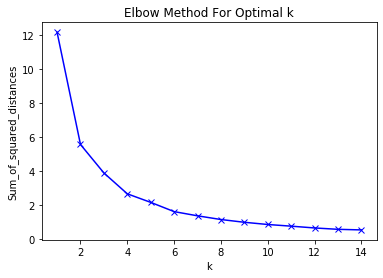

In [47]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the above plot, we choose k=6 for the number of clusters

In [48]:
kclusters = 6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(to_data_n2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 5, 3, 1, 4, 3, 3, 2, 0], dtype=int32)

Adding the clustering labels to our main dataframe

In [49]:
# add clustering labels
to_data_n.insert(1, 'Cluster Labels', kmeans.labels_)
to_data_n.head()

,PostalCode,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Population,Average_income,Num_of_gyms,Pop_income,Inv_gym
0,M3A,1,North York,Parkwoods,43.753259,-79.329656,23575.0,71966.0,0,0.396403,1.000000
1,M4A,3,North York,Victoria Village,43.725882,-79.315572,9405.0,60491.0,2,0.096138,0.800000
2,M5A,5,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,32905.0,63542.0,19,0.501380,0.253571
3,M6A,3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,13490.0,62881.0,2,0.170519,0.800000
4,M9A,1,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,24065.0,117148.0,0,0.695308,1.000000


### 7- Visualizing the clusters using *folium*

In [51]:
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1.2, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, Num_of_gyms, Pop_income, nbr, cluster in zip(to_data_n['Latitude'], to_data_n['Longitude'], to_data_n['Num_of_gyms'],
                                        to_data_n['Pop_income'],to_data_n['Neighborhood'], to_data_n['Cluster Labels']):
    label = folium.Popup(str(nbr) +' Num_of_gyms'+ ' ' + str(Num_of_gyms) +
                         ' Cluster ' + str(cluster) + ' ' +'Pop_income' +' ' + str(Pop_income), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 8- choosing better neighborhoods

The more suitable neighborhoods will be chosen based on the number f existing gyms in each neighborhood and the product of population between 15 to 64 and households average income.

Checking different cluster, better neighborhoods can be found in **cluster 1**(zero or very low number of Gyms and moderate or high pop_income), after these neighborhoods the next choice can be from the **cluster 4**(low or moderate number of Gyms, high or very high pop_income). 

**Note**: pop_income shows the normalized value of the product of population and household average income.

In [53]:
to_cluster1= to_data_n[to_data_n['Cluster Labels'] ==1]
to_cluster1.head()

,PostalCode,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Population,Average_income,Num_of_gyms,Pop_income,Inv_gym
0,M3A,1,North York,Parkwoods,43.753259,-79.329656,23575.0,71966.0,0,0.396403,1.00
4,M9A,1,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,24065.0,117148.0,0,0.695308,1.00
10,M9B,1,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,21765.0,97197.0,1,0.507942,0.89
11,M1C,1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,23980.0,103716.0,0,0.606892,1.00
13,M4C,1,East York,Woodbine Heights,43.695344,-79.318389,32785.0,66633.0,0,0.526333,1.00


In [54]:
to_cluster4= to_data_n[to_data_n['Cluster Labels'] ==4]
to_cluster4.head()

,PostalCode,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Population,Average_income,Num_of_gyms,Pop_income,Inv_gym
5,M1B,4,Scarborough,"Malvern, Rouge",43.806686,-79.194353,45135.0,70929.0,2,0.797079,0.800000
18,M4E,4,East Toronto,The Beaches,43.676357,-79.293031,17295.0,107144.0,3,0.438063,0.725000
22,M4G,4,East York,Leaside,43.709060,-79.363452,12575.0,156052.0,5,0.467166,0.607143
30,M6H,4,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,33880.0,68678.0,5,0.564209,0.607143
32,M2J,4,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,40240.0,68092.0,3,0.674234,0.725000
